# Sprint7課題 機械学習スクラッチクラスタリング  

##  この課題の目的

- スクラッチを通してK-meansを理解する
- クラスタ分析を行う

## スクラッチによる実装

NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

## 【問題1】K-meansクラスの作成

非階層クラスタリングの手法であるK-meansのクラスを作成してください。名前はScratchKMeansとしてください。

教師なし学習であるクラスタリングになるため、ここまでの回帰や分類とは異なるパイプラインを作成することになります。

メソッドやパラメータなどはscikit-learnを参考にしてください。

[sklearn.cluster.KMeans — scikit-learn 0.20.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめてください。

### クラスタリングのための人工データセット

クラスタリングを実験するための人工データセットを作成するコードを用意しました。スクラッチの過程で利用してください。

このmake_blobs関数は正解ラベルも出力してますが、今回は使用しません。使用しないことを明示するために、 _（アンダースコア） で受け取っています。

In [1]:
from sklearn.datasets import make_blobs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import seaborn as sns

In [2]:
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, 
                                  cluster_std=0.5, shuffle=True, random_state=0)

## 目的関数

K-meansは以下のクラスタ内誤差平方和（SSE, Sum of Squared Errors）を最小化する$r_{nk}$と$\mu_k$
を求めることで学習を行います。この数式自体は学習時にはコーディングする必要がありませんが、クラスタ数$K$を決めるためのエルボー法で使います。エルボー法の実装は問題2で扱います。

$$ SSE = \sum_{n=1}^N \sum_{k=1}^K r_{nk} \|X_n - \mu_k\|^2 $$

$n$ : データ点のインデックス

$k$ : クラスタのインデックス

$X_n$ : $n$番目のデータ点

$\mu_k$ : $k$番目の中心点

$r_{nk}$ : データ点$X_n$がクラスタ$k$に所属していたら1、そうでなければ0

### 学習

K-meansの学習の基本は以下の2つのフェーズを繰り返すことです。

- 中心点 
$\mu_k$を固定した上で $J$を最小化する$r_{nk}$を選ぶ。
- $r_{nk}$を固定した上で$J$を最小化する$\mu_k$を選ぶ。

具体的には以下を行います。

まずは

- 中心点$\mu_k$の初期値を決める。

その後以下を繰り返します。

- データ点$X_n$を最も近い$\mu_k$に割り当てる。
- 中心点$\mu_k$を$k$番目のクラスタに割り当てられる全てのデータ点$X_n$の平均値（重心）に移動する。

次のどれかの条件を満たしたらこれを止めます。

- 繰り返しが指定した回数に到達する。
- 中心点$\mu_k$と重心の差が指定した許容値以下になる。
- データ点$X_n$のクラスタへの割り当てが変化しなくなる。

さらに、

- ここまでの一連の流れを指定した回数繰り返す。
- SSEが最小になったものを最終的な学習結果とする。

これで学習が完了します。

考慮すべき点として、空のクラスタが生じる可能性があります。これを防ぐためには以下の動作を実装します。

- $k$番目のクラスタに割り当てられるデータ点$X_n$が存在しない場合、中心点$\mu_k$を最も離れているデータ点の場所に移動する。

繰り返し回数や許容値などのハイパーパラメータの値はscikit-learnのデフォルト値を参考にしてください。

### ユーグリット距離  

K-menasにおける 近い とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル$p, q$
 に対しては以下の数式で表現できます。
 
 $$\|q-p\| = \sqrt{(q-p)\cdot(q-p)}$$
 
 NumPyにはこの関数がnp.linalg.normとして用意されているため使用してください。

参考

[numpy.linalg.norm — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.norm.html)

### 初期値  

K-meansの学習結果は中心点$\mu$の初期値に影響を受けます。

最もシンプルな初期値の決定方法は、データ点$X_n$の中からランダムに$k$個選ぶことです。今回はこれを実装してください。

K-meansのより良い初期値の選択方法については研究が行われており、いろいろな方法が提案されています。

### 推定

新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。

- データ点$X_n$に対し、学習で決まった中心点$\mu_k$の元、$J$を最小化する$r_{nk}$
を選ぶ。

具体的には次のことです。

- データ点$X_n$を最も近い$\mu_k$に割り当てる。

In [3]:
class ScratchKMeans():
    '''
    K-meansのクラス
        
    Parameters
    --------------
    n_clusters : int
        クラスターの数
    n_init : int
        K-meansアルゴリズムが異なる重心で実行される回数
    max_iter : int
        K-meansアルゴリズムの最大反復回数
    tol : float
        収束する際の誤差
        
    Attributes
    -------------
    center : 次の形のndarray, shape (n_clusters, n_features)
        中心点
    clusters : 次の形のndarray, shape (n_samples, )
        クラスタ
    sse : float
        クラスタ内誤差平方和
    '''
    def __init__(self, n_clusters=4, n_init=10, max_iter=100, tol=1e-4):
        #ハイパーパラメータ
        self.n_clusters = n_clusters #クラスター数
        self.n_init         = n_init         #異なる重心で実行される回数
        self.max_iter    = max_iter   #最大のイテレーション回数
        self.tol               = tol              #収束する際の誤差
        
        #インスタンス変数
        self.center   = None #中心点
        self.clusters = None #クラスタ
        self.sse         = None #SSE
        
        
    def fit(self, X):
        '''
        クラスタリングの学習
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        '''
        #中心点を設定
        self.center = self._choice_center(X)
        
        #イテレーションの回数実行
        for iteration in range(self.max_iter):
            
            #中心点との距離を入れる配列
            distance = np.zeros((X.shape[0], self.n_clusters))

            #クラスタの数だけデータとの距離を求める
            for i in range(self.n_clusters):
                euclid = np.linalg.norm(X - self.center[i], axis=1)
                
                #求めた距離を格納
                distance[:, i] += euclid            

            #各データと中心が最小の距離
            min_distance = np.amin(distance, axis=1, keepdims=True)
            
            #各データが割り当てられるクラスタの配列
            _, clusters = np.where(distance==min_distance)
            
            # dict{クラスター名: データの数}
            cluster_count = {i: len(clusters[clusters == i]) for i in np.unique(clusters)}
            
            #クラスターに割り当てられるデータ点が０のとき、そのクラスター名を取得
            dic = [k for k, v in cluster_count.items() if v == 0]            
            
            #距離が一番遠いものを選ぶ
            for i in dic:
                max_distance = max(distance[:, i])
                
                #距離が一番遠い時の行数を取得
                x_idx, _ = np.where(distance==max_distance)
                
                #中心点を一番遠い所にする
                self.center[i, :] == X[x_idx, :]            

            #重心を求める
            new_center = np.array([X[clusters == i].mean(axis=0) for i in range(self.n_clusters)])

            #中心点と重心が指定した誤差以下となればbreak
            if np.all(abs(new_center - self.center) <= self.tol):
                break
                
            #クラスターが同じならbreak
            if np.all(self.clusters == clusters):
                break
            
            #中心点の更新
            self.center = new_center

            #クラスターの更新
            self.clusters = clusters

            
    def fit_predict(self, X):
        '''
        クラスタリングの学習と推定
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
            
        Returns
        ----------
        self.clusters : 次の形のndarray, shape (n_samples, )
            推定したクラスター
        '''
        #中心点を設定
        self.center = self._choice_center(X)
        
        #イテレーションの回数実行
        for iteration in range(self.max_iter):
            
            #中心点との距離を入れる配列
            distance = np.zeros((X.shape[0], self.n_clusters))

            #クラスタの数だけデータとの距離を求める
            for i in range(self.n_clusters):
                euclid = np.linalg.norm(X - self.center[i], axis=1)
                
                #求めた距離を格納
                distance[:, i] += euclid            

            #各データと中心が最小の距離
            min_distance = np.amin(distance, axis=1, keepdims=True)
            
            #各データが割り当てられるクラスタの配列
            _, clusters = np.where(distance==min_distance)
            
            # dict{クラスター名: データの数}
            cluster_count = {i: len(clusters[clusters == i]) for i in np.unique(clusters)}
            
            #クラスターに割り当てられるデータ点が０のとき、そのクラスター名を取得
            dic = [k for k, v in cluster_count.items() if v == 0]            
            
            #距離が一番遠いものを選ぶ
            for i in dic:
                max_distance = max(distance[:, i])
                
                #距離が一番遠い時の行数を取得
                x_idx, _ = np.where(distance==max_distance)
                
                #中心点を一番遠い所にする
                self.center[i, :] == X[x_idx, :]            

            #重心を求める
            new_center = np.array([X[clusters == i].mean(axis=0) for i in range(self.n_clusters)])

            #中心点と重心が指定した誤差以下となればbreak
            if np.all(abs(new_center - self.center) == self.tol):
                break
                
            #クラスターが同じならbreak
            if np.all(self.clusters == clusters):
                break
            
            #中心点の更新
            self.center = new_center

            #クラスターの更新
            self.clusters = clusters
            
        return self.clusters
    

    def predict(self, X):
        '''
        クラスタリングによる推定
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
            
        Returns
        ----------
        self.clusters : 次の形のndarray, shape (n_samples, )
            推定したクラスタ
        '''
        #中心点との距離を入れる配列
        distance = np.zeros((X.shape[0], self.n_clusters))
        
        #クラスタの数だけデータとの距離を求める
        for i in range(X.shape[0]):
            euclid = np.linalg.norm(X[i] - self.center, axis=1)
                
            #求めた距離を格納
            distance[i, :] += euclid    
            
        #各データと中心が最小の距離
        min_distance = np.amin(distance, axis=1, keepdims=True)
            
        #各データが割り当てられるクラスタの配列
        _, clusters = np.where(distance==min_distance)
        
        return clusters
                
    
    def _choice_center(self, X):
        '''
        中心点を決める
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
            
        Returns
        ----------
        self.cenrer : 次の形のndarray, shape (n_clusters, n_features)
            推定した中心点
        '''
        sse_min_list = [] #sseを入れるリスト
        center = [] #中心点を入れるリスト
        
        #イテレーション数実行
        for i in range(self.n_init):

            #データの行番号をランダムに取得(重複なし)
            row = X.shape[0]
            idx = np.random.choice(row, self.n_clusters, replace=False)

            #中心点の初期値
            self.center = X[idx]
            
            #中心点をリストに格納
            center.append(self.center)
            
            #中心点との距離を入れる配列
            distance = np.zeros([X.shape[0], self.center.shape[0]])
            
            #クラスタの数だけデータとの距離を求める
            for i in range(self.n_clusters):
                euclid = np.linalg.norm(X - self.center[i], axis=1)
                
                #求めた距離を格納
                distance[:, i] += euclid

            #各データと中心が最小の距離
            min_distance = np.amin(distance, axis=1, keepdims=True)
            
            #各データが割り当てられるクラスタの配列
            _, clusters = np.where(distance==min_distance)
            
            #sseを入れるリスト(1つの中心点)
            sse_list = []
            
            for k in range(self.n_clusters):
                for n in range(X.shape[0]):
                    
                    #データがクラスタに属していたら1, それ以外は0
                    if clusters[n] == k:
                        r = 1
                    else:
                        r = 0
                        
                    #SSEをリストに格納
                    sse_list.append(r * np.linalg.norm(X[n] - self.center[k])**2)
  
            #1イテレーションのSSEをリストに格納
            sse_min_list.append(np.sum(sse_list))
        
        #全てのイテレーションの中で一番小さいSSEを取得
        self.sse = min(sse_min_list)
        
        #SSEが一番小さい時のindexを取得
        min_index = sse_min_list.index(self.sse)
        
        #中心点を決める
        self.center = center[min_index]
       
        return self.center

In [4]:
km = ScratchKMeans()
km.fit_predict(X)

array([3, 0, 3, 3, 3, 3, 1, 0, 3, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2, 3, 0,
       1, 2, 3, 1, 1, 3, 2, 2, 2, 0, 2, 2, 1, 3, 0, 2, 0, 1, 3, 1, 0, 1,
       1, 0, 2, 1, 3, 3, 3, 2, 1, 1, 1, 0, 0, 2, 2, 0, 0, 2, 2, 3, 2, 0,
       1, 1, 2, 3, 0, 2, 3, 0, 3, 3, 1, 1, 2, 2, 2, 0, 1, 3, 2, 1, 2, 2,
       3, 3, 3, 1, 3, 1, 1, 0, 0, 1, 0, 3])

In [5]:
km.center

array([[-1.26811733,  7.76378266],
       [-1.47935679,  3.11716896],
       [ 1.99186903,  0.96561071],
       [ 0.92578447,  4.32475792]])

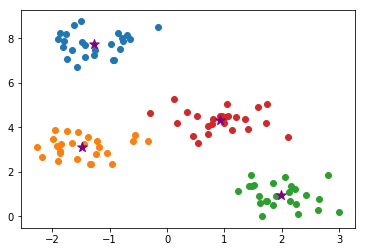

In [6]:
for i in range(X.shape[0]):
    plt.scatter(X[km.clusters ==i, 0], X[km.clusters == i, 1])
    
plt.scatter(km.center[:, 0], km.center[:, 1],color='purple', marker='*', s=100);

## 【問題2】エルボー法の実装

K-meansにおいて中心点の個数$k$は人為的に決める必要があるが、その判断方法としてエルボー法があります。

SSEを縦軸、クラスタ数$k$を横軸にした折れ線グラフを表示します。

このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

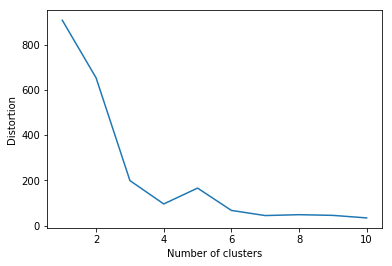

In [7]:
elbow = []
for i in range(1, 11):
    km = ScratchKMeans(n_clusters=i)
    km.fit(X)
    elbow.append(km.sse)

plt.plot(range(1, 11), elbow)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

## 【問題3】（アドバンス課題）シルエット図

## クラスタリング分析
### 卸売業者のデータ分析  

クラスタリングを利用法を学ぶために、Wholesale customers Data Setを使用します。

[UCI Machine Learning Repository: Wholesale customers Data Set](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)

Data Folderの中からWholesale customers data.csv</font>をダウンロードしてください。これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。顧客は小売店やレストランです。RegionとChannelは取り覗き、金額のデータでK-meansを利用します。

In [8]:
#データの抜き出し
df = pd.read_csv('Wholesale customers data.csv')

#RegionとChannelは削除
data = df.drop(['Region', 'Channel'], axis=1)

data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [9]:
#データをnparrayにし、対数変換
X = np.log(data.values)

### 次元削減

金額に関する特徴量は6個ありますが、可視化するために次元削減を行います。これに関してはscikit-learnによるPCAのサンプルコードを用意したので利用してください。

In [10]:
#PCAのサンプルコード
pca = PCA(n_components = 2)
pca = pca.fit(X)
data_pca = pca.transform(X)

[0.44237417 0.71894523 0.83511865 0.93129585 0.97705265 1.        ]


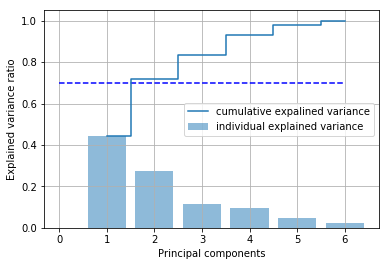

In [11]:
#PCAの分散説明率を表示するコードサンプル
pca = PCA(n_components=None)
pca = pca.fit(X)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

## 【問題4】クラスタ数kの選択

最適だと思われるクラスタ数$k$を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。

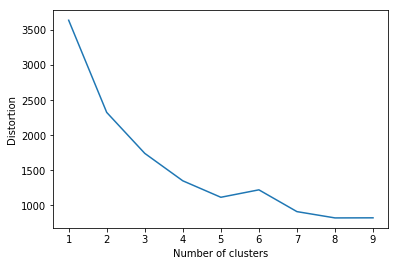

In [12]:
#エルボー法
elbow = []
for i in range(1, 10):
    km = ScratchKMeans(n_clusters=i, n_init=15, max_iter=200)
    km.fit_predict(data_pca)
    elbow.append(km.sse)

plt.plot(range(1, 10), elbow)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

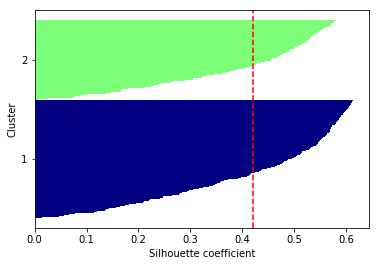

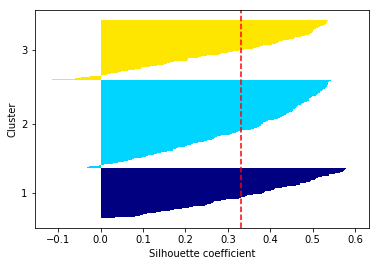

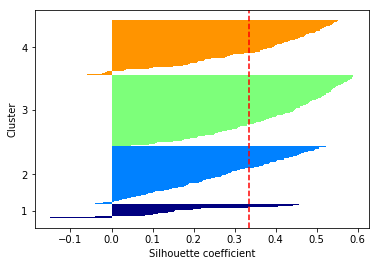

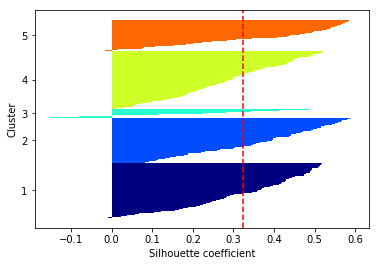

In [13]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

#クラスタ数2~5でシルエット図
for i in range(2, 6):
    #学習、推定
    km = ScratchKMeans(n_clusters=i, n_init=15, max_iter=200)
    y_km = km.fit_predict(data_pca)

    #クラスタのラベル名の配列
    cluster_labels = np.unique(y_km)

    #クラスタ数
    n_clusters = cluster_labels.shape[0]

    #シルエット係数
    silhouette_vals = silhouette_samples(data_pca, y_km, metric='euclidean')

    #シルエット係数の平均値
    silhouette_avg = np.mean(silhouette_vals)

    #シルエット図を表示
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()

今回のデータセットは顧客が年間でミルクや食料品等を何ユーロで購入しているかというデータである。顧客がどういった組み合わせの商品を購入するかを予測し、それによって商品の配列等を考えるのに利用できると思われる。

エルボー法を用いた時、肘の位置はクラスタ数が2以降あたりの位置であった。クラスタ数2~5でシルエット図を見ると、クラスタ数2が一番サンプル数が偏りなく、クラスタ同士も離れているように感じたため、2を採用する。

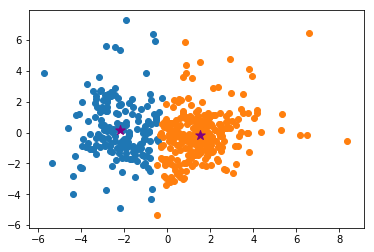

In [14]:
# クラスタ2つでクラスタリング
km = ScratchKMeans(n_clusters=2, n_init=15, max_iter=200)
y_km = km.fit_predict(data_pca)

for i in range(data_pca.shape[0]):
    plt.scatter(data_pca[km.clusters ==i, 0], data_pca[km.clusters == i, 1])
    
plt.scatter(km.center[:, 0], km.center[:, 1],color='purple', marker='*', s=100);

## 【問題5】既知のグループとの比較

RegionとChannelはK-meansに使用しなかったが、これらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

In [15]:
#PCAしたデータにRegionとChannelを追加
df_data_pca = pd.DataFrame(data_pca)
df_data_pca['Region'] = df['Region']
df_data_pca['Channel'] = df['Channel']
df_data_pca.head()

,0,1,Region,Channel
0,-1.750985,-0.070515,3,2
1,-1.800365,-0.869754,3,2
2,-1.893736,-1.676621,3,2
3,1.127313,-1.457982,3,1
4,-0.796711,-2.460866,3,2


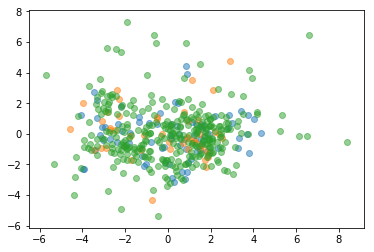

In [16]:
#Regionの散布図
plt.scatter(df_data_pca[df_data_pca['Region'] == 1][0], df_data_pca[df_data_pca['Region'] == 1][1], alpha=0.5)
plt.scatter(df_data_pca[df_data_pca['Region'] == 2][0], df_data_pca[df_data_pca['Region'] == 2][1], alpha=0.5)
plt.scatter(df_data_pca[df_data_pca['Region'] == 3][0], df_data_pca[df_data_pca['Region'] == 3][1], alpha=0.5);

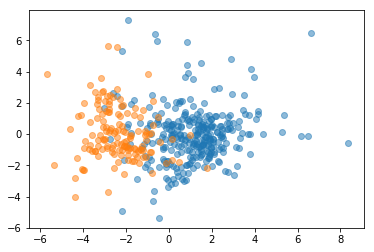

In [17]:
#Cannelの散布図
plt.scatter(df_data_pca[df_data_pca['Channel'] == 1][0], df_data_pca[df_data_pca['Channel'] == 1][1], alpha=0.5)
plt.scatter(df_data_pca[df_data_pca['Channel'] == 2][0], df_data_pca[df_data_pca['Channel'] == 2][1], alpha=0.5);

RegionとChannelにおいて、グループごとに色分けし、散布図を出力した。Regionではクラスタと異なって、グループごとにデータが混ざり合った分布となっていた。また、Channelでは、クラスタリングしたものと似たような分布を示しており、それとはあまり違いは見られなかった。

## 【問題6】卸売業者にとって有益な情報

卸売業者にとって有益な情報を探し出し文章にまとめてください。

ヒント

前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。

条件ごとにデータを見る際にはPandasのgroupbyが便利です。

[pandas.DataFrame.groupby — pandas 0.23.4 documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)

In [18]:
#要約統計量
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


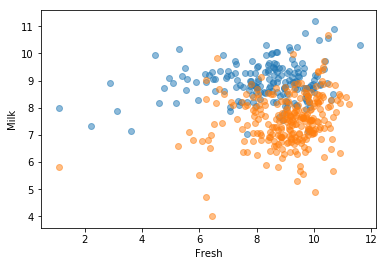

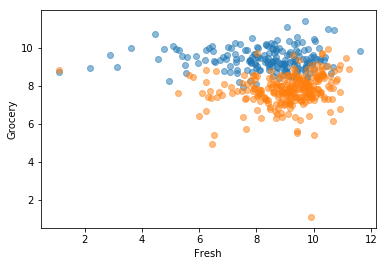

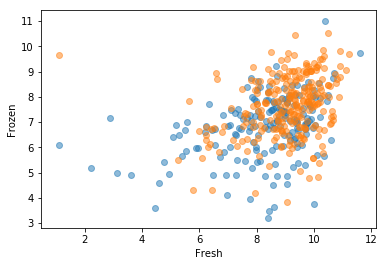

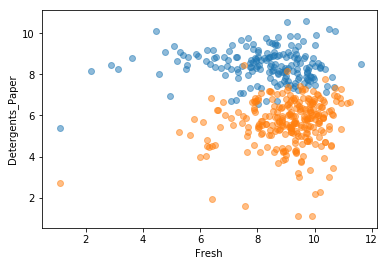

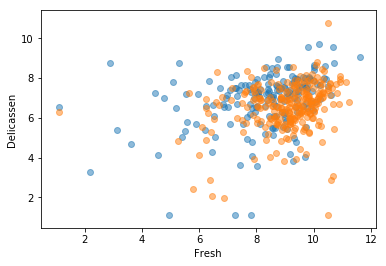

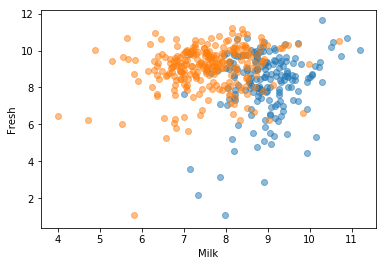

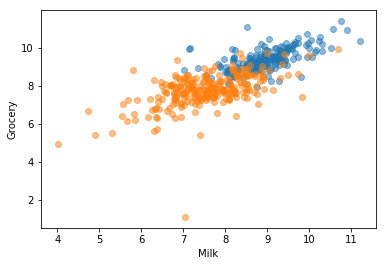

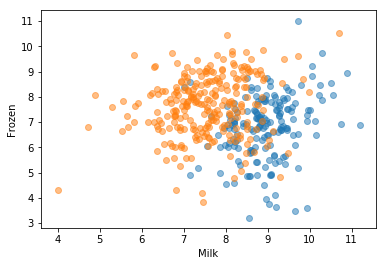

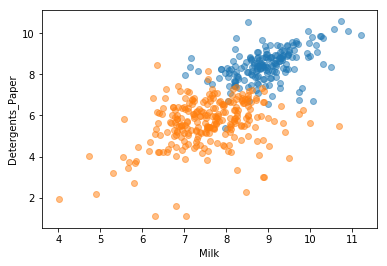

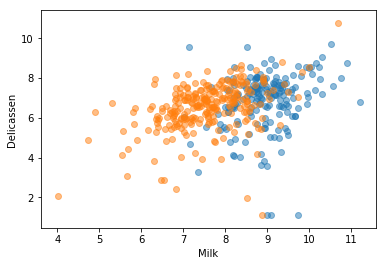

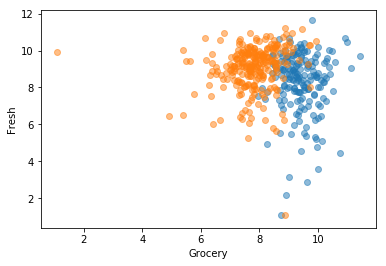

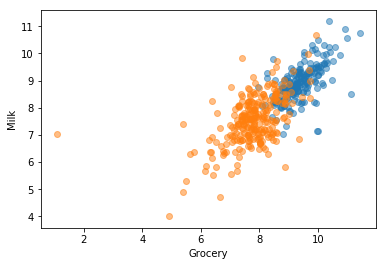

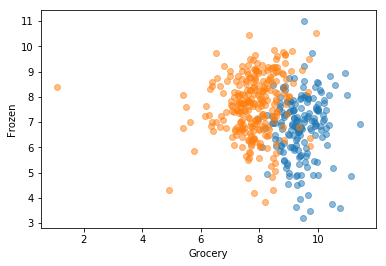

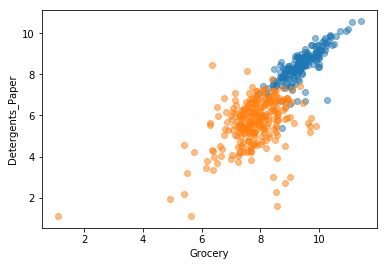

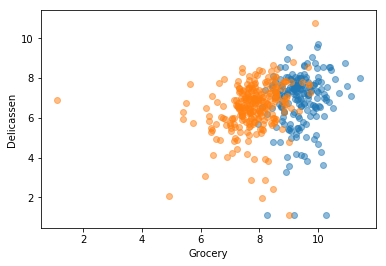

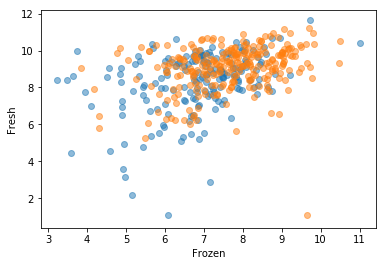

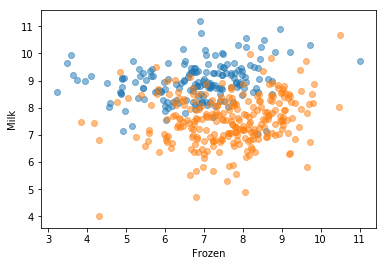

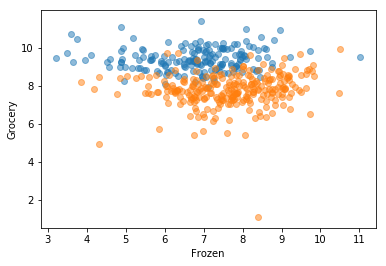

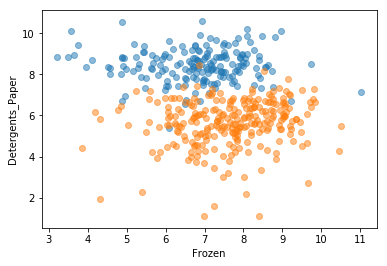

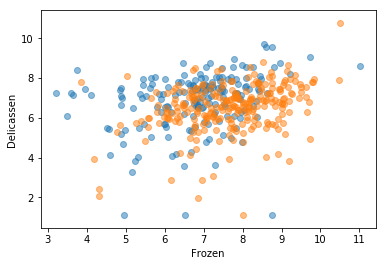

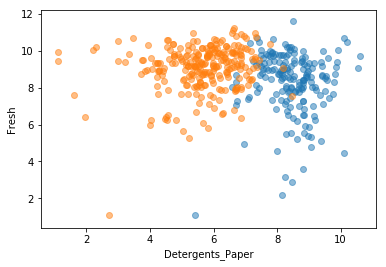

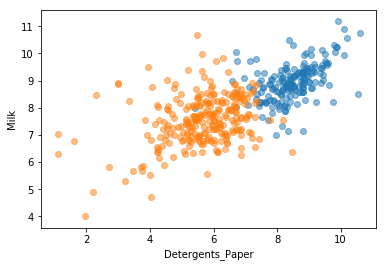

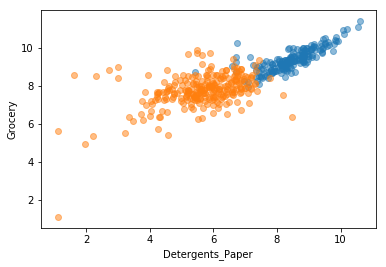

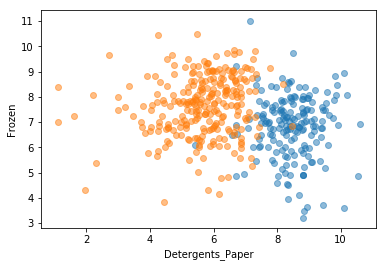

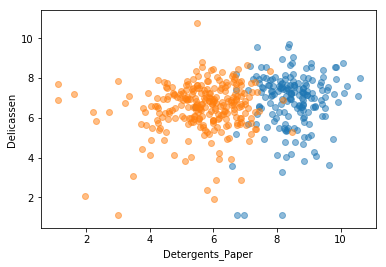

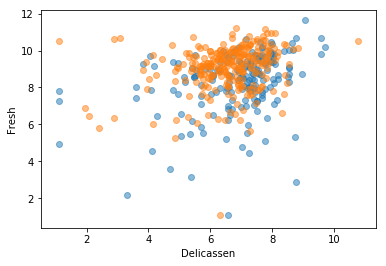

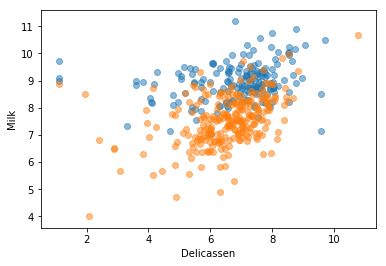

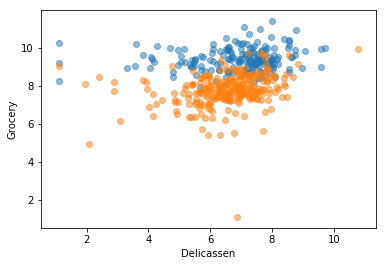

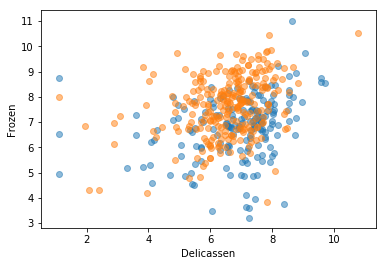

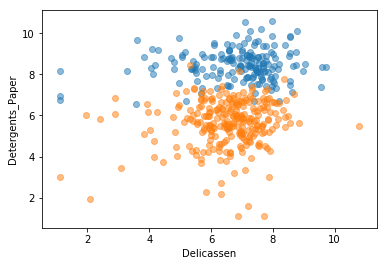

In [19]:
#特徴量名
data_col = data.columns

#各特徴量同士でクラスタごとの分布を見る
for i in data_col:
    for j in data_col:
        
        #同じ特徴量は出力しない
        if i != j:
            
            #特徴量をnparrayにし、対数変換
            data_choice = np.log(df[[i, j]].values)
            
            # クラスター2つで可視化
            plt.scatter(data_choice[km.clusters ==0, 0], data_choice[km.clusters ==0, 1], alpha=0.5)
            plt.scatter(data_choice[km.clusters ==1, 0], data_choice[km.clusters ==1, 1], alpha=0.5)
            plt.xlabel(i)
            plt.ylabel(j)
            
            plt.show()

In [20]:
#dataにクラスタを追加
data['Cluster'] = y_km

#クラスタごとの数を確認
data['Cluster'].value_counts()

1    260
0    180
Name: Cluster, dtype: int64

In [21]:
#クラスタごとの各特徴量の平均を出力
data.groupby(['Cluster']).mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,
0,8932.155556,9982.611111,14779.494444,1936.205556,6373.344444,1864.072222
1,14124.396154,2898.026923,3224.050000,3858.203846,464.057692,1290.038462


In [22]:
#Channelごとの各特徴量の平均を出力
df.groupby(['Channel']).mean()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,,,,,,,
1,2.510067,13475.560403,3451.724832,3962.137584,3748.251678,790.560403,1415.956376
2,2.612676,8904.323944,10716.500000,16322.852113,1652.612676,7269.507042,1753.436620


In [23]:
#Regionごとの各特徴量の平均を出力
df.groupby(['Region']).mean()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Region,,,,,,,
1,1.233766,11101.727273,5486.415584,7403.077922,3000.337662,2651.116883,1354.896104
2,1.404255,9887.680851,5088.170213,9218.595745,4045.361702,3687.468085,1159.702128
3,1.332278,12533.471519,5977.085443,7896.363924,2944.594937,2817.753165,1620.601266


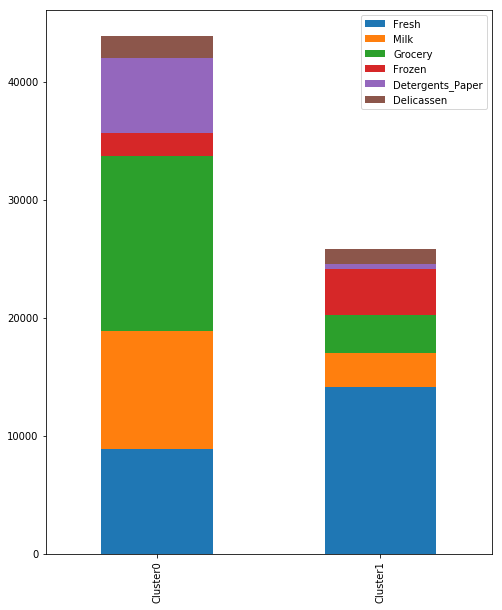

In [24]:
#空のデータフレーム
df_cluster = pd.DataFrame()

#クラスタごとの各商品価格の平均を積み上げ式棒グラフとして出力
for i in range(len(data['Cluster'].unique())):
    df_cluster['Cluster' + str(i)] = data[data['Cluster'] == i].mean()
df_cluster = df_cluster.drop('Cluster')

df_cluster.T.plot(kind='bar', stacked=True, figsize=(8, 10));

今回クラスタ0に属するのは180の顧客、1に属するのは260の顧客であった。

各特徴量同士を1つずつ組み合わせて、クラスタリングしたものがどのように分布しているかを確認した。クラスタごとにある程度分かれていたのは、特徴量としてMilk, Grocery, Detergents_Paperを用いたものであった。

また、各商品の平均を積み上げ式棒グラフとして出力したグラフを見ると、クラスタ0は1と比較してMilk, Grocery, Detergents_Paperの値が大きく
、クラスタ1では0と比較してFresh, Frozenの値が大きかった。

結果として、クラスタ0ではMilk, Grocery, Detergents_Papeをよく購入する傾向があり、クラスタ1では、Fresh, Frozenをよく購入する傾向があると思われる。

これはChannelごとの価格平均と似ており、今回の場合、クラスタ0がChannel2にあたり、クラスタ1がChannel1にあたる。

## 他の非階層クラスタリング手法

## 【問題7】（アドバンス課題）他の手法の調査

今回扱ったK-means以外に非階層クラスタリングで有名な手法としては DBSCAN 、
PCA以外に次元削減手法で有名な手法としては t-SNE や LLE があります。

- DBSCANのメリット・デメリット
- t-SNE、LLEのメリット・デメリット

について記述してください。

**クラスタリング**

- DBSCANのメリット
    - クラスタが球状であることを前提としない
    - 点をそれぞれクラスタに割り当てる必要がなく、ノイズを除去できる
    
- DBSCANのデメリット
    - 計算コストが高い
    - クラスタの密度に差が大きいと、クラスタリングが上手くできない
    
**次元削減**
- t-SNE、LLEのメリット
    - 非線形な変換を行える。(多様体学習)

- t-SNE、LLEのデメリット
    - データの局所的な構造を見る際の、局所的な範囲が問題になる。近傍を大きく取り過ぎると線形ではない場所で線形と仮定することになり、小さすぎると上手く構造が見出だせなくなる。

## 【問題8】（アドバンス課題）t-SNEとDBSCANの利用

Wholesale customersのデータに対して、PCAではなく、 t-SNE を用いて次元削減をしてください。さらにK-meansではなく、 DBSCAN を用いてクラスタリングしてください。

そのクラスタリング結果をPCA+kmeansの場合の結果と比較してみましょう。実装にはscikit-learnを用いてください。

[sklearn.manifold.TSNE — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

[sklearn.cluster.DBSCAN — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

パラメーターチューニング

これらはK-meansやPCAに比べパラメーターチューニングが難しい手法です。scikit-learnのドキュメントと共に論文も参考にしながらパラメータの意味を確認することも大切になります。

[t-SNEの論文](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

[DBSCANの論文](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

In [37]:
#TSNE
tsne = TSNE(n_components=2, perplexity=130, n_iter=5000)
data_tsne = tsne.fit_transform(X)

In [38]:
#DBSCAN
dbscan = DBSCAN(eps=1, min_samples=15)
dbscan_pred = dbscan.fit_predict(data_tsne)

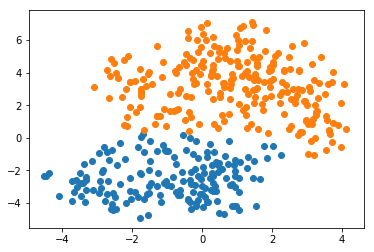

In [39]:
for i in range(data_tsne.shape[0]):
    plt.scatter(data_tsne[dbscan.labels_ ==i, 0], data_tsne[dbscan.labels_ == i, 1])

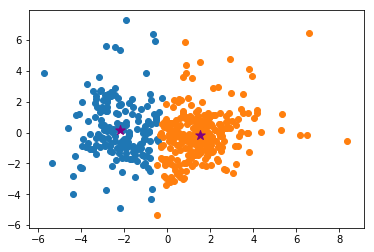

In [28]:
# クラスタ2つでクラスタリング
km = ScratchKMeans(n_clusters=2, n_init=15, max_iter=200)
y_km = km.fit_predict(data_pca)

for i in range(data_pca.shape[0]):
    plt.scatter(data_pca[km.clusters ==i, 0], data_pca[km.clusters == i, 1])
    
plt.scatter(km.center[:, 0], km.center[:, 1],color='purple', marker='*', s=100);

設定したパラメータの意味
- TSNE
    - n_components  
    削減後の次元数
    - perplexity  
    データ同士の関係の評価の際にどれだけ近傍の点を考慮するか
    - n_iter  
    イテレーション数
    
    
- DBSCAN
    - eps  
    隣接点とみなす 2 点間の最大距離
    - min_samples  
    ボーダー点の最大個数
    
クラスタ数はK-meansと同じ2つになった。しかし、分かれている方向はK-meansは縦に分割されていたが、DBSCANは横に分割されていた。また、パラメータチューニングが難しく、K-meansと同じような散布図にするのが難しかった。

## 【問題9】教師なし学習と教師あり学習

最終発表時に以下の内容についてディスカッションを行います。自分なりの意見を用意しておいてください。

- 教師なし学習は教師あり学習とどのような違いがあるか

注意点

答えがある問いではありません。いろいろな視点から見て理解を深めていきましょう。

- 教師あり学習
正解の分かっているデータからモデルを学習し、未知のデータに対して予測できるようにすること。正解データが連続値の回帰と、正解データが離散値の分類が存在する。

- 教師なし学習
正解が分からないデータや構造が不明なデータから、グループや法則を見つけ出す。